In [1]:
import glob
import math
import os
import re
from collections import defaultdict, OrderedDict
from dataclasses import make_dataclass
from functools import partial
from itertools import chain, islice
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import wandb
from clearml import Task
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

TELEGRAM_TOKEN = '1664508454:AAGwZ1rSk55nNFeYNvwYv-39k2AWGTJKXBg'
TELEGRAM_CHAT_ID = '412118128'
if TELEGRAM_TOKEN and TELEGRAM_CHAT_ID:
    from tqdm.contrib.telegram import tqdm as tg_tqdm
    tg_tqdm = partial(tg_tqdm, token=TELEGRAM_TOKEN, chat_id=TELEGRAM_CHAT_ID)
else:
    tg_tqdm = tqdm

from utils import decode_rle, _prefix_dictionary_keys

In [2]:
PROJECT_NAME = os.path.basename(os.path.abspath(''))
TASK_NAME = 'DiNTS'

In [3]:
CONFIG = {
    'num_epochs': 1,
    'num_folds': 5,
    # data loading
    'batch_size': 8,
    # model config
    'channel_mul': 2.0,
    'num_blocks': 12,
    'num_depths': 4,
    'use_downsample': False,
    # optimization
    'net_sgd_momentum': 0.9,
    'net_sgd_weight_decay': 4e-5,
    'net_sgd_lr_warmup_start': 0.025,
    'net_sgd_lr_warmup_end': 0.2,
    'net_sgd_lr_warmup_end_step': 1000,
    'net_sgd_lr_decay_factor': 0.2,
    'net_sgd_lr_decay_steps': [8000, 16000],
    'arch_adam_lr': 0.008,
    'arch_adam_weight_decay': 0,
}

config = make_dataclass('Config', CONFIG.keys())(**CONFIG)

config.num_epochs = math.ceil(config.num_epochs / config.num_folds) * config.num_folds  # ensure config.num_epochs is multiple of config.num_folds

In [4]:
data_path = Path(os.path.abspath('')) / 'data'
df = pd.read_csv(data_path / 'train.csv', converters={'segmentation': lambda x: np.array(list(map(int, x.split())), dtype=np.uint32)})
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,[]
1,case123_day20_slice_0001,small_bowel,[]
2,case123_day20_slice_0001,stomach,[]
3,case123_day20_slice_0002,large_bowel,[]
4,case123_day20_slice_0002,small_bowel,[]


In [5]:
slices_df = df.groupby(['id', 'class']).first().segmentation.unstack().reset_index()
id_pattern = re.compile(r'(?P<case_day>(?P<case>case\d+)_day\d+)_(?P<slice>slice_\d+)')
slices_df[ 'glob_path_pattern' ] = slices_df.id.apply(lambda id: '{case}/{case_day}/scans/{slice}_*.png'.format(**id_pattern.match(id).groupdict()))
slices_df.iloc[0].large_bowel

array([], dtype=uint32)

38496
>>>>> 2533
(1, 256, 256) (1, 256, 256)


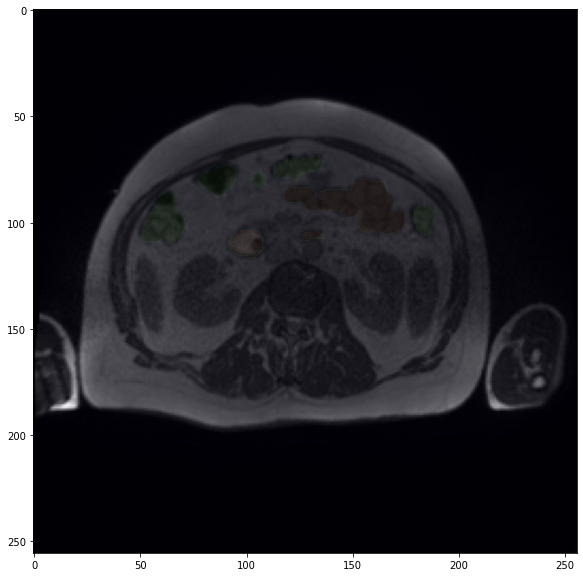

In [6]:
IMAGE_SIZE = (256, 256)

class Dataset(torch.utils.data.Dataset):
    classes = ('large_bowel', 'small_bowel', 'stomach')

    def __init__(self, slices_df, img_dir, transform=None):
        self.slices_df = slices_df
        self.img_dir = img_dir
        self.transform = transform

    def __getitem__(self, index):
        slice = self.slices_df.iloc[index]
        img_path = glob.glob(os.path.join(self.img_dir, slice.glob_path_pattern))[0]
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img = img.astype(np.float32) / 0xFFFF
        original_size = img.shape[-2:]
        #print(original_size)

        target_size = IMAGE_SIZE
        img = cv2.resize(img, target_size, cv2.INTER_CUBIC)
        segmentation_masks = [np.zeros(target_size, dtype=np.float32)]
        for cls in self.classes:
            rle = slice[cls]
            segmentation_masks.append(
                cv2.resize(decode_rle(rle, original_size), dsize=target_size, interpolation=cv2.INTER_LINEAR)
            )
        
        # Sampled images must have (num_channeld, spacial_H, spacial_W) dimensions,
        # in order to be processed with monai.transforms.* .
        sample = dict(image=img[np.newaxis, ...], mask=np.argmax(np.stack(segmentation_masks), axis=0, keepdims=True))

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.slices_df)

d = Dataset(slices_df, img_dir=data_path / 'train')
print(len(d))
n = 1110
for i in range(1, len(d)):
    sample = d[i]
    img, mask = sample['image'], sample['mask']
    n -= np.any(mask > 0)
    if n == 0:
        print('>>>>>', i)
        print(img.shape, mask.shape)
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img.mean(axis=0), 'gray')
        ax.imshow(mask.squeeze(axis=0), 'jet', alpha=0.05)
        plt.show()
        break

In [7]:
from monai.transforms import *

train_transform = Compose([
    # RandRotated(keys=['image', 'mask'], range_x=1.5, prob=0.2, mode=['bilinear', 'nearest']),
    RandFlipd(keys=['image', 'mask'], spatial_axis=0, prob=0.5),
    RandFlipd(keys=['image', 'mask'], spatial_axis=0, prob=0.5),
])
val_transform = Compose([

])

In [8]:
from monai.data.utils import partition_dataset
from sklearn.model_selection import KFold

MAX_BATCH_SIZE_LIMIT = 2

cv_splitter = KFold(n_splits=config.num_folds, shuffle=True, random_state=42)

def dataloader_from_splits(*, n_repeats):
    for train_indices, val_indices in islice(cv_splitter.split(slices_df), n_repeats):
        train_slices_df, val_slices_df = slices_df.iloc[train_indices], slices_df.iloc[val_indices]
        # train_slices_df = partition_dataset(data=train_slices_df, num_partitions=1, shuffle=False)[0]
        # val_slices_df = partition_dataset(data=val_slices_df, num_partitions=1, shuffle=False)[0]

        train_dataset = Dataset(train_slices_df, img_dir=data_path / 'train', transform=train_transform)
        val_dataset = Dataset(val_slices_df, img_dir=data_path / 'train', transform=val_transform)
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=min(MAX_BATCH_SIZE_LIMIT, config.batch_size),
            sampler=torch.utils.data.SubsetRandomSampler(np.arange(len(train_slices_df))),
            drop_last=True,
        )
        val_dataloader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=min(MAX_BATCH_SIZE_LIMIT, config.batch_size),
            sampler=torch.utils.data.SubsetRandomSampler(np.arange(len(val_slices_df))),
            drop_last=True,
        )
        yield train_dataloader, val_dataloader

train_dataloader, val_dataloader = next(dataloader_from_splits(n_repeats=1))
print(next(iter(train_dataloader))['image_transforms'])

[{'class': ['RandFlipd', 'RandFlipd'], 'id': tensor([139882432966416, 139882432966416]), 'orig_size': [tensor([256, 256]), tensor([256, 256])], 'do_transforms': tensor([False,  True])}, {'class': ['RandFlipd', 'RandFlipd'], 'id': tensor([139882432964832, 139882432964832]), 'orig_size': [tensor([256, 256]), tensor([256, 256])], 'do_transforms': tensor([True, True])}]


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
from monai.networks.nets import DiNTS, TopologySearch

arch_model = TopologySearch(
    num_blocks=12,
    num_depths=4,
    spatial_dims=2,
    use_downsample=False,
    device=device,
)
model = DiNTS(
    dints_space=arch_model,
    in_channels=1, 
    num_classes=1+3,
    spatial_dims=2,
    use_downsample=False,
    node_a=None, # search automatically
)

In [11]:
from monai.losses import DiceCELoss

model = model.to(device)
dice_ce_loss = DiceCELoss(include_background=False, to_onehot_y=True, softmax=True).forward
net_optimizer = torch.optim.SGD(model.weight_parameters(), lr=config.net_sgd_lr_warmup_end,
                                momentum=config.net_sgd_momentum, weight_decay=config.net_sgd_weight_decay)
lr_fn = lambda i: (config.net_sgd_lr_warmup_start + i * (config.net_sgd_lr_warmup_end - config.net_sgd_lr_warmup_start) / config.net_sgd_lr_warmup_end_step
                   if i < config.net_sgd_lr_warmup_end_step
                   else config.sgd_lr_warmup_end * config.net_sgd_lr_decay_factor ** sum(i > s for s in config.net_sgd_lr_decay_steps))
net_scheduler = torch.optim.lr_scheduler.LambdaLR(net_optimizer, lr_fn)
arch_optimizer = torch.optim.Adam(arch_model.parameters(), lr=config.arch_adam_lr, weight_decay=config.arch_adam_weight_decay)

In [12]:
wandb.init(project=PROJECT_NAME, name=TASK_NAME, config=config, resume=True)
wandb.tensorboard.patch(save=False, pytorch=True)

task = Task.init(project_name=PROJECT_NAME, task_name=TASK_NAME)
task.connect(config)

wandb: Currently logged in as: karatach1998. Use `wandb login --relogin` to force relogin


ClearML Task: created new task id=01f4254e535b44fcae9e2e020aa5d7c8
2022-06-16 19:38:12,009 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.community.clear.ml/projects/2d97198122334ac2b30fd98136087bbb/experiments/01f4254e535b44fcae9e2e020aa5d7c8/output/log


Config(num_epochs=5, num_folds=5, batch_size=8, channel_mul=2.0, num_blocks=12, num_depths=4, use_downsample=False, net_sgd_momentum=0.9, net_sgd_weight_decay=4e-05, net_sgd_lr_warmup_start=0.025, net_sgd_lr_warmup_end=0.2, net_sgd_lr_warmup_end_step=1000, net_sgd_lr_decay_factor=0.2, net_sgd_lr_decay_steps=[8000, 16000], arch_adam_lr=0.008, arch_adam_weight_decay=0)

In [50]:
from monai.metrics import compute_meandice

writer = SummaryWriter()

acc_steps = config.batch_size // MAX_BATCH_SIZE_LIMIT
for epoch, (train_dataloader, val_dataloader) in enumerate(dataloader_from_splits(n_repeats=config.num_epochs)):
    model.train()
    with tg_tqdm(iter(train_dataloader),
                 desc=f"Train {TASK_NAME} [{(epoch+1):3d}/{config.num_epochs}]",
                 ncols=200) as pbar:
        acc_loss = 0
        for idx, sample in enumerate(pbar):
            task.set_prgress(int(100 * (epoch + idx / config.num_epochs) / len(slices_df)))

            image = sample['image'].to(device)
            mask = sample['mask'].to(device)

            pred = model(image)
            loss = dice_ce_loss(pred, mask)
            loss = loss / acc_steps 
            acc_loss = acc_loss + loss.detach()
            loss.backward()

            if (idx+1) % acc_steps == 0:
                net_optimizer.step()
                net_scheduler.step()
                arch_optimizer.step()
                model.zero_grad()

                step = epoch * config.num_epochs + idx // acc_steps
                with torch.no_grad():
                    metrics = OrderedDict([(k, v.cpu().numpy()) for k, v in [
                        ('MeanDice', compute_meandice(pred, torch.nn.functional.one_hot(mask.squeeze(1), 4).permute(0, 3, 1, 2), ignore_empty=False).mean()),
                        ('Loss', acc_loss),
                    ]])
                pbar.set_postfix(net_lr=net_scheduler.get_last_lr()[0], **metrics)
                #wandb.log(dict(chain(metrics.items()), loss=acc_loss, net_lr=net_scheduler.get_last_lr()[-1]))
                for name, value in _prefix_dictionary_keys(metrics, 'Train/').items():
                    writer.add_scalar(name, value, step)
                acc_loss = 0
    
    model.eval()
    with tqdm(enumerate(val_dataloader), desc=f"Val {TASK_NAME} [{(epoch+1):3d}/{config.num_epochs}", ncols=200) as pbar:
        acc_metrics = defaultdict(list)
        for idx, sample in pbar:
            task.set_prgress(int(100 * (epoch + (len(train_dataloader) + idx) / config.num_epochs) / len(slices_df)))

            image = sample['image'].to(device)
            mask = sample['mask'].to(device)

            with torch.no_grad():
                pred = model(image)

            acc_metrics['MeanDice'].append(compute_meandice(pred, torch.nn.functional.one_hot(mask.squeeze(1), 4).permute(0, 3, 1, 2), ignore_empty=False).mean())

        metrics = OrderedDict([(k, torch.cat(v).mean().cpu().numpy()) for k, v in acc_metrics])
        pbar.set_postfix(**metrics)
        #wandb.log(dict(chain(metrics.items()), loss=acc_loss, net_lr=net_scheduler.get_last_lr()[-1]))
        for name, value in _prefix_dictionary_keys(metrics, 'Val/').items():
            writer.add_scalar(name, value, epoch)

Train [  1/5]:   0%|                                                                                          …